<h2>Median Filtering </h2>

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter


<h3>Read Image</h3>

In [2]:
image_path = '../images/lane2.jpeg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
noisy_image = image_rgb.copy()

<h3>Add salt and pepper Noise and Display</h3>

In [3]:
# noise_prob = 0.5
# noise = np.random.rand(noisy_image.shape[0], noisy_image.shape[1])

# noisy_image[noise < noise_prob/2] = 0
# noisy_image[noise > 1 - noise_prob/2] = 255

# plt.figure()
# plt.imshow(noisy_image)

# plt.show()



<h3>Apply Median Filter</h3>

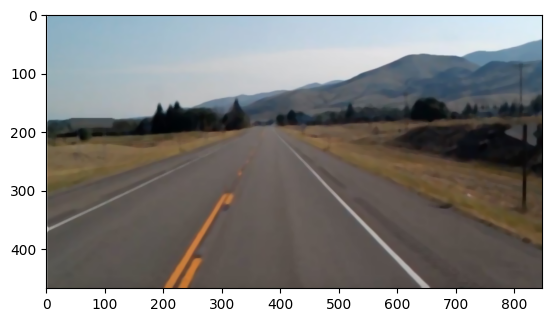

In [4]:
median_filter = cv2.medianBlur(noisy_image, 7)
plt.figure()
plt.imshow(median_filter)

plt.show()

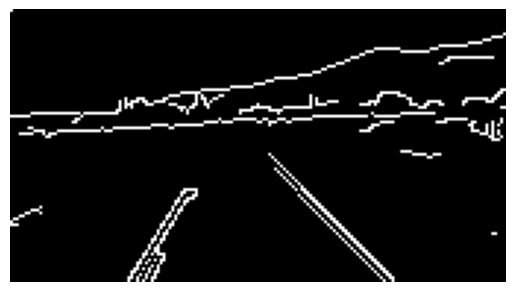

In [5]:

height, width, _ = median_filter.shape
scale = 1/5

height_scale = int(height * scale)
width_scale = int(width * scale)
img = cv2.resize(median_filter, (width_scale, height_scale), interpolation=cv2.INTER_LINEAR)

canny_edge = cv2.Canny(img, 200, 255)

plt.figure()
plt.imshow(canny_edge, cmap='gray')  
plt.axis('off')  
plt.show()


<h3>ROI</h3>

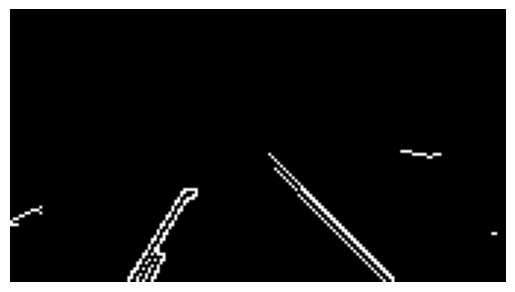

In [ ]:
height, width = canny_edge.shape 


mask = np.zeros_like(canny_edge)


top_mask = np.array([[(0, 0), (width, 0), (width, height // 2), (0, height // 2)]], dtype=np.int32)


cv2.fillPoly(mask, top_mask, 255)


mask = cv2.bitwise_not(mask)


masked_edges = cv2.bitwise_and(canny_edge, mask)

# plt.figure()
# plt.imshow(mask, cmap='gray')  
# plt.axis('off')  
# plt.show()

plt.figure()
plt.imshow(masked_edges, cmap='gray')  
plt.axis('off')  
plt.show()


<h3>Masked Image</h3>

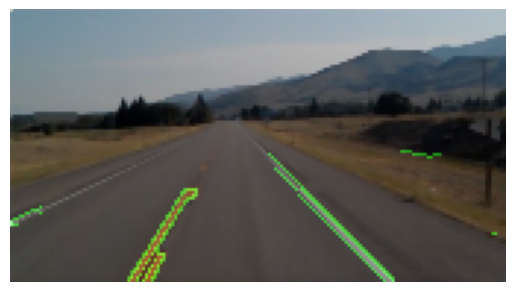

In [7]:
edges_colored = np.zeros_like(img)  
edges_colored[:, :, 1] = masked_edges 


highlighted = cv2.addWeighted(img, 0.8, edges_colored, 0.5, 0)

plt.figure()
plt.imshow(highlighted)
plt.axis('off')
plt.show()


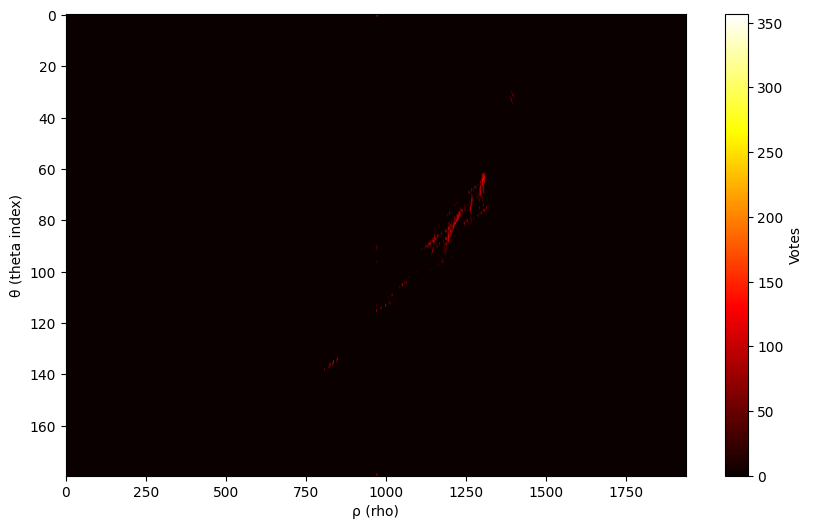

In [8]:
image = cv2.imread('../images/lane2.jpeg', cv2.IMREAD_GRAYSCALE)
image = cv2.equalizeHist(image)


edges = cv2.Canny(image, 200, 255)


height, width = edges.shape

theta_range = np.deg2rad(np.arange(0, 180))   
rho_max = int(np.hypot(height, width))       
rho_range = np.arange(-rho_max, rho_max)      


accumulator = np.zeros((len(theta_range), 2 * rho_max), dtype=np.int32)


edge_points = np.argwhere(edges > 0)


for y, x in edge_points:
    for theta_idx, theta in enumerate(theta_range):
        rho = int(x * np.cos(theta) + y * np.sin(theta))
        rho_idx = rho + rho_max   
        accumulator[theta_idx, rho_idx] += 1


threshold = 75
accumulator[accumulator < threshold] = 0  


plt.figure(figsize=(10, 6))
plt.imshow(accumulator, cmap='hot', aspect='auto')
plt.colorbar(label="Votes")
plt.xlabel("ρ (rho)")
plt.ylabel("θ (theta index)")
plt.show()


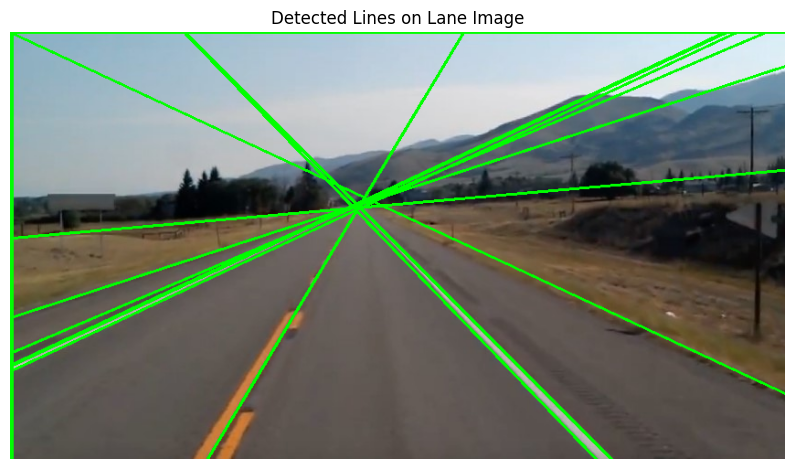

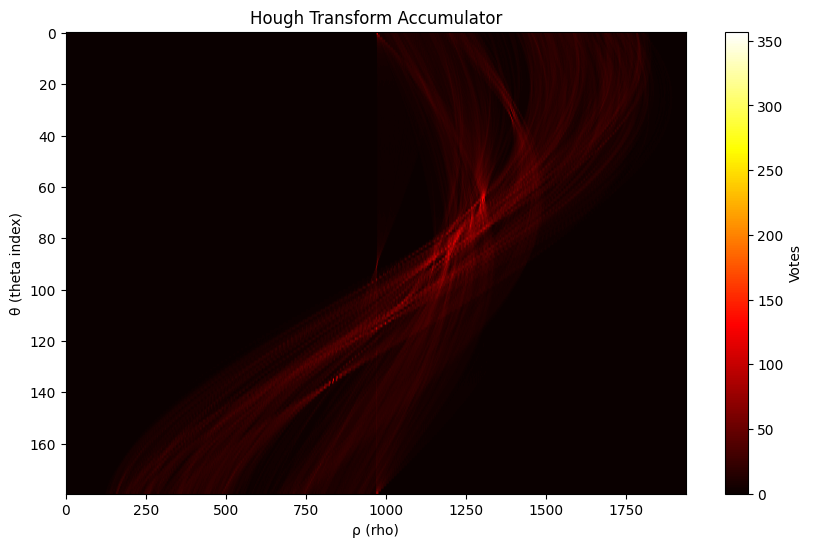

In [ ]:
image = cv2.imread('../images/lane2.jpeg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray = cv2.equalizeHist(gray)

edges = cv2.Canny(gray, 200, 255)

height, width = edges.shape

theta_range = np.deg2rad(np.arange(0, 180))   
rho_max = int(np.hypot(height, width))       
rho_range = np.arange(-rho_max, rho_max)      


accumulator = np.zeros((len(theta_range), 2 * rho_max), dtype=np.int32)


edge_points = np.argwhere(edges > 0)


for y, x in edge_points:
    for theta_idx, theta in enumerate(theta_range):
        rho = int(x * np.cos(theta) + y * np.sin(theta))
        rho_idx = rho + rho_max   
        accumulator[theta_idx, rho_idx] += 1


threshold = 150
strong_votes = np.argwhere(accumulator > threshold)


image_with_lines = image.copy()
for theta_idx, rho_idx in strong_votes:
    rho = rho_idx - rho_max
    theta = theta_range[theta_idx]


    a = np.cos(theta)
    b = np.sin(theta)
    x0, y0 = a * rho, b * rho


    x1 = int(x0 + 1000 * (-b)) 
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))

    cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)


image_with_lines_rgb = cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(10, 6))
plt.imshow(image_with_lines_rgb)
plt.axis("off")
plt.title("Detected Lines on Lane Image")
plt.show()


plt.figure(figsize=(10, 6))
plt.imshow(accumulator, cmap='hot', aspect='auto')
plt.colorbar(label="Votes")
plt.xlabel("ρ (rho)")
plt.ylabel("θ (theta index)")
plt.title("Hough Transform Accumulator")
plt.show()


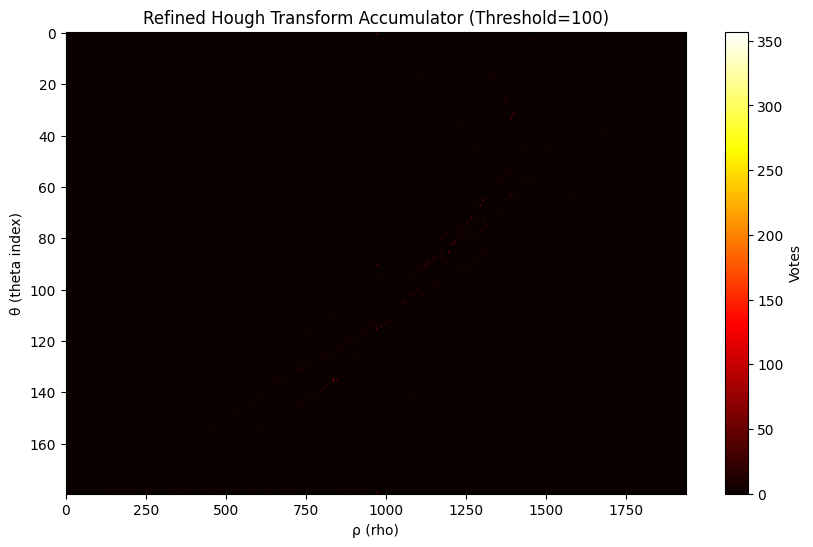

In [37]:
nms_size = 5  
maxima = maximum_filter(accumulator, size=nms_size)
accumulator[accumulator < maxima] = 0 


plt.figure(figsize=(10, 6))
plt.imshow(accumulator, cmap='hot', aspect='auto')
plt.colorbar(label="Votes")
plt.xlabel("ρ (rho)")
plt.ylabel("θ (theta index)")
plt.title(f"Refined Hough Transform Accumulator (Threshold={threshold})")
plt.show()
